# Recyclable and Household Waste Classification with PyramidNet+ASAM
  - Paper : [ASAM: Adaptive Sharpness-Aware Minimization for Scale-Invariant Learning of Deep Neural Networks
](https://arxiv.org/abs/2102.11600)

1. PyramidNet
  - Residual Network의 한 변형으로, 층이 깊어질수록 채널 수가 점진적으로 증가하도록 설계
  - CIFAR-10, CIFAR-100 같은 데이터셋에서 높은 성능


2. ASAM
  - 기존의 SAM(Sharpness-Aware Minimization)은 파라미터 스케일 변경에 민감해 sharpness와 일반화 격차 사이의 상관관계가 약화되는 문제가 존재
  - ASAM은 스케일 의존성을 제거


3. 구현
- [PyramidNet](https://github.com/dyhan0920/PyramidNet-PyTorch)
    - Fine-tuning이 아닌 Full-training으로 구현
    - 하이퍼파라미터인 ```alpha```와 ```depth```를 증가시킬수록 모델의 Trainable Parameter가 점진적으로 증가함
    - 따라서 ```depth = 110```으로 논문과 동일하게 설정, ```alpha = 48```으로 PyramidNet 구현 중에서 가장 작은 수로 설정
- [ASAM](https://github.com/SamsungLabs/ASAM)


4. 한계
- Full-training으로 인해 GPU 자원의 부족으로 충분한 학습을 진행하지 못함
- Base optimizer가 SGD이기 때문에 갱신 속도가 느려, 충분한 학습 진행이 어려움


5. 향후 보완점
- CIFAR-100으로 학습한 PyramidNet의 사전 학습 레이어를 동결해서 활용하여 ASAM의 효과를 확인할 수 있음


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. 라이브러리 및 데이터 불러오기

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import random
import math
import zipfile
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from timm.loss import LabelSmoothingCrossEntropy

In [ ]:
%cd /content/drive/MyDrive/SWE3052
sys.path.append('/content/drive/MyDrive/SWE3052')

/content/drive/MyDrive/SWE3052


### 1. PyramidNet, ASAM

```PyramidNet.py```

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    outchannel_ratio = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        shortcut = x

        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        if out.size(1) != shortcut.size(1):
            padding = torch.zeros(out.size(0), out.size(1) - shortcut.size(1), out.size(2), out.size(3), device=out.device)
            shortcut = torch.cat([shortcut, padding], dim=1)

        out += shortcut
        out = self.relu(out)
        return out


class Bottleneck(nn.Module):
    outchannel_ratio = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * Bottleneck.outchannel_ratio, kernel_size=1, bias=False)
        self.bn4 = nn.BatchNorm2d(planes * Bottleneck.outchannel_ratio)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        shortcut = x

        out = self.bn1(x)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn4(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        if out.size(1) != shortcut.size(1):
            padding = torch.zeros(out.size(0), out.size(1) - shortcut.size(1), out.size(2), out.size(3), device=out.device)
            shortcut = torch.cat([shortcut, padding], dim=1)

        out += shortcut
        out = self.relu(out)
        return out


class PyramidNet(nn.Module):
    def __init__(self, dataset, depth, alpha, num_classes, bottleneck=False):
        super(PyramidNet, self).__init__()
        self.dataset = dataset
        self.inplanes = 16 if dataset.startswith('cifar') else 64

        block = Bottleneck if bottleneck else BasicBlock
        n = (depth - 2) // (9 if bottleneck else 6)
        self.addrate = alpha / (3 * n)

        self.input_featuremap_dim = self.inplanes
        self.conv1 = nn.Conv2d(3, self.input_featuremap_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.input_featuremap_dim)

        self.featuremap_dim = self.input_featuremap_dim
        self.layer1 = self.pyramidal_make_layer(block, n)
        self.layer2 = self.pyramidal_make_layer(block, n, stride=2)
        self.layer3 = self.pyramidal_make_layer(block, n, stride=2)

        self.final_featuremap_dim = self.input_featuremap_dim
        self.bn_final = nn.BatchNorm2d(self.final_featuremap_dim)
        self.relu_final = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.final_featuremap_dim, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def pyramidal_make_layer(self, block, block_depth, stride=1):
        downsample = None
        if stride != 1:
            downsample = nn.AvgPool2d((2, 2), stride=stride)

        layers = []
        self.featuremap_dim += self.addrate
        layers.append(block(self.input_featuremap_dim, int(round(self.featuremap_dim)), stride, downsample))
        for _ in range(1, block_depth):
            temp_featuremap_dim = self.featuremap_dim + self.addrate
            layers.append(block(int(round(self.featuremap_dim)), int(round(temp_featuremap_dim))))
            self.featuremap_dim = temp_featuremap_dim
        self.input_featuremap_dim = int(round(self.featuremap_dim))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.bn_final(x)
        x = self.relu_final(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


```asam.py```

In [ ]:
class ASAM:
    def __init__(self, optimizer, model, rho=0.5, eta=0.01):
        self.optimizer = optimizer
        self.model = model
        self.rho = rho
        self.eta = eta
        self.state = defaultdict(dict)

    @torch.no_grad()
    def ascent_step(self):
        wgrads = []
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            t_w = self.state[p].get("eps")
            if t_w is None:
                t_w = torch.clone(p).detach()
                self.state[p]["eps"] = t_w
            if 'weight' in n:
                t_w[...] = p[...]
                t_w.abs_().add_(self.eta)
                p.grad.mul_(t_w)
            wgrads.append(torch.norm(p.grad, p=2))
        wgrad_norm = torch.norm(torch.stack(wgrads), p=2) + 1.e-16
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            t_w = self.state[p].get("eps")
            if 'weight' in n:
                p.grad.mul_(t_w)
            eps = t_w
            eps[...] = p.grad[...]
            eps.mul_(self.rho / wgrad_norm)
            p.add_(eps)
        self.optimizer.zero_grad()

    @torch.no_grad()
    def descent_step(self):
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            p.sub_(self.state[p]["eps"])
        self.optimizer.step()
        self.optimizer.zero_grad()


class SAM(ASAM):
    @torch.no_grad()
    def ascent_step(self):
        grads = []
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            grads.append(torch.norm(p.grad, p=2))
        grad_norm = torch.norm(torch.stack(grads), p=2) + 1.e-16
        for n, p in self.model.named_parameters():
            if p.grad is None:
                continue
            eps = self.state[p].get("eps")
            if eps is None:
                eps = torch.clone(p).detach()
                self.state[p]["eps"] = eps
            eps[...] = p.grad[...]
            eps.mul_(self.rho / grad_norm)
            p.add_(eps)
        self.optimizer.zero_grad()


### 2. Dataset, Dataloader 정의

In [ ]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)

                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]

                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# 에포크 수 및 하이퍼파라미터 설정
num_epochs = 200
batch_size = 8 # 논문은 128
learning_rate = 0.1
rho = 0.5
eta = 0.0
depth = 110 # 110과 164 사용
alpha = 48 # 200, 270, 300 사용

In [ ]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
root_dir = "./data/images/images"
train_dataset = WasteDataset(root_dir, split='train', transform=transform)
val_dataset = WasteDataset(root_dir, split='val', transform=transform)
test_dataset = WasteDataset(root_dir, split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 3. 모델 불러오기

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(f'Current device is {device} \nReserved GPU Memory: {(torch.cuda.memory_reserved() / 1024**2):.2f} MB \nAllocated GPU Memory: {(torch.cuda.memory_allocated() / 1024**2):.2f} MB')

Current device is cuda 
Reserved GPU Memory: 0.00 MB 
Allocated GPU Memory: 0.00 MB


In [ ]:
# 모델, 옵티마이저, 스케쥴러, 손실함수 정의
model = PyramidNet(dataset='cifar100', depth=depth, alpha=alpha, num_classes=len(train_dataset.classes)).to(device)
base_optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
optimizer = ASAM(base_optimizer, model, rho=rho, eta=eta)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.optimizer, T_max=num_epochs)
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1774006


### 3. 모델 학습

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm을 배치 루프에 적용
    train_bar = tqdm(train_loader, desc="Training", leave=True)

    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.optimizer.zero_grad()

        # Ascent Step
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.mean().backward()
        optimizer.ascent_step()

        # Descent Step
        criterion(model(inputs), labels).mean().backward()
        optimizer.descent_step()

        running_loss += loss.sum().item()
        _, predicted = predictions.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # tqdm 바 업데이트
        train_bar.set_postfix({
            "Loss": f"{running_loss / total:.4f}",
            "Accuracy": f"{100. * correct / total:.2f}%"
        })

    return running_loss / total, 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    eval_bar = tqdm(loader, desc="Evaluating", leave=True)

    with torch.no_grad():
        for inputs, labels in eval_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            running_loss += loss.sum().item()
            _, predicted = predictions.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # tqdm 바 업데이트
            eval_bar.set_postfix({
                "Loss": f"{running_loss / total:.4f}",
                "Accuracy": f"{100. * correct / total:.2f}%"
            })

    return running_loss / total, 100. * correct / total

In [ ]:
def trainer(num_epochs, model, train_loader, val_loader, optimizer, device, patience=5):
    # 모델 저장, 조기 종료 조건 설정
    best_val_accuracy = 0.0
    best_val_loss = float('inf')
    counter = 0

    # 히스토리 저장
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    # 학습 시작
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # 학습
        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)

        # 검증
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        # 히스토리에 추가
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # 학습률 업데이트
        scheduler.step()

        # 최고 성능 모델 저장 (validation accuracy 기준)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # 개선되면 counter 초기화
        else:
            counter += 1  # 개선되지 않으면 counter 증가

        if counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs")
            break

    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [ ]:
%%time
train_loss_history, val_loss_history, train_acc_history, val_acc_history = trainer(num_epochs, model, train_loader, val_loader, optimizer, device, patience=5)


Epoch 1/200


Evaluating: 100%|██████████| 375/375 [05:46<00:00,  1.08it/s, Loss=0.3969, Accuracy=13.30%]


Train Loss: 0.4135, Train Accuracy: 8.19%
Val Loss: 0.3969, Val Accuracy: 13.30%

Epoch 2/200


Evaluating: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s, Loss=0.3915, Accuracy=12.63%]


Train Loss: 0.3916, Train Accuracy: 13.53%
Val Loss: 0.3915, Val Accuracy: 12.63%

Epoch 3/200


Evaluating: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s, Loss=0.3774, Accuracy=17.63%]


Train Loss: 0.3763, Train Accuracy: 17.94%
Val Loss: 0.3774, Val Accuracy: 17.63%

Epoch 4/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s, Loss=0.3952, Accuracy=20.50%]


Train Loss: 0.3646, Train Accuracy: 21.47%
Val Loss: 0.3952, Val Accuracy: 20.50%

Epoch 5/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.66it/s, Loss=0.3513, Accuracy=26.50%]


Train Loss: 0.3532, Train Accuracy: 24.87%
Val Loss: 0.3513, Val Accuracy: 26.50%

Epoch 6/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.62it/s, Loss=0.3378, Accuracy=30.20%]


Train Loss: 0.3410, Train Accuracy: 27.10%
Val Loss: 0.3378, Val Accuracy: 30.20%

Epoch 7/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s, Loss=0.3273, Accuracy=34.97%]


Train Loss: 0.3308, Train Accuracy: 29.78%
Val Loss: 0.3273, Val Accuracy: 34.97%

Epoch 8/200


Evaluating: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s, Loss=0.3160, Accuracy=35.07%]


Train Loss: 0.3243, Train Accuracy: 31.12%
Val Loss: 0.3160, Val Accuracy: 35.07%

Epoch 9/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s, Loss=0.3135, Accuracy=38.00%]


Train Loss: 0.3141, Train Accuracy: 33.74%
Val Loss: 0.3135, Val Accuracy: 38.00%

Epoch 10/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s, Loss=0.3042, Accuracy=40.87%]


Train Loss: 0.3096, Train Accuracy: 35.49%
Val Loss: 0.3042, Val Accuracy: 40.87%

Epoch 11/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s, Loss=0.3170, Accuracy=37.63%]


Train Loss: 0.3058, Train Accuracy: 37.00%
Val Loss: 0.3170, Val Accuracy: 37.63%

Epoch 12/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.66it/s, Loss=0.2927, Accuracy=44.70%]


Train Loss: 0.3006, Train Accuracy: 38.10%
Val Loss: 0.2927, Val Accuracy: 44.70%

Epoch 13/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s, Loss=0.2894, Accuracy=42.37%]


Train Loss: 0.2961, Train Accuracy: 40.07%
Val Loss: 0.2894, Val Accuracy: 42.37%

Epoch 14/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s, Loss=0.2913, Accuracy=43.90%]


Train Loss: 0.2930, Train Accuracy: 40.78%
Val Loss: 0.2913, Val Accuracy: 43.90%

Epoch 15/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s, Loss=0.2948, Accuracy=42.80%]


Train Loss: 0.2924, Train Accuracy: 40.47%
Val Loss: 0.2948, Val Accuracy: 42.80%

Epoch 16/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s, Loss=0.2840, Accuracy=45.33%]


Train Loss: 0.2890, Train Accuracy: 41.78%
Val Loss: 0.2840, Val Accuracy: 45.33%

Epoch 17/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s, Loss=0.2957, Accuracy=41.27%]


Train Loss: 0.2884, Train Accuracy: 42.32%
Val Loss: 0.2957, Val Accuracy: 41.27%

Epoch 18/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s, Loss=0.2860, Accuracy=43.77%]


Train Loss: 0.2843, Train Accuracy: 43.18%
Val Loss: 0.2860, Val Accuracy: 43.77%

Epoch 19/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s, Loss=0.2980, Accuracy=40.50%]


Train Loss: 0.2837, Train Accuracy: 43.38%
Val Loss: 0.2980, Val Accuracy: 40.50%

Epoch 20/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s, Loss=0.2790, Accuracy=45.33%]


Train Loss: 0.2815, Train Accuracy: 44.39%
Val Loss: 0.2790, Val Accuracy: 45.33%

Epoch 21/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s, Loss=0.2715, Accuracy=48.77%]


Train Loss: 0.2796, Train Accuracy: 45.14%
Val Loss: 0.2715, Val Accuracy: 48.77%

Epoch 22/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s, Loss=0.2685, Accuracy=50.77%]


Train Loss: 0.2772, Train Accuracy: 45.54%
Val Loss: 0.2685, Val Accuracy: 50.77%

Epoch 23/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s, Loss=0.2799, Accuracy=46.20%]


Train Loss: 0.2788, Train Accuracy: 44.88%
Val Loss: 0.2799, Val Accuracy: 46.20%

Epoch 24/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s, Loss=0.2871, Accuracy=47.93%]


Train Loss: 0.2774, Train Accuracy: 45.26%
Val Loss: 0.2871, Val Accuracy: 47.93%

Epoch 25/200


Evaluating: 100%|██████████| 375/375 [00:31<00:00, 11.73it/s, Loss=0.2876, Accuracy=45.00%]


Train Loss: 0.2757, Train Accuracy: 45.43%
Val Loss: 0.2876, Val Accuracy: 45.00%

Epoch 26/200


Evaluating: 100%|██████████| 375/375 [00:31<00:00, 11.72it/s, Loss=0.2694, Accuracy=50.13%]


Train Loss: 0.2734, Train Accuracy: 47.18%
Val Loss: 0.2694, Val Accuracy: 50.13%

Epoch 27/200


Evaluating: 100%|██████████| 375/375 [00:32<00:00, 11.71it/s, Loss=0.2756, Accuracy=50.07%]

Train Loss: 0.2729, Train Accuracy: 46.40%
Val Loss: 0.2756, Val Accuracy: 50.07%
Early stopping after 27 epochs
Best Validation Accuracy: 50.77%
CPU times: user 5h 30min 37s, sys: 31min 23s, total: 6h 2min
Wall time: 4h 26min 31s


### 4. Test 성능 확인

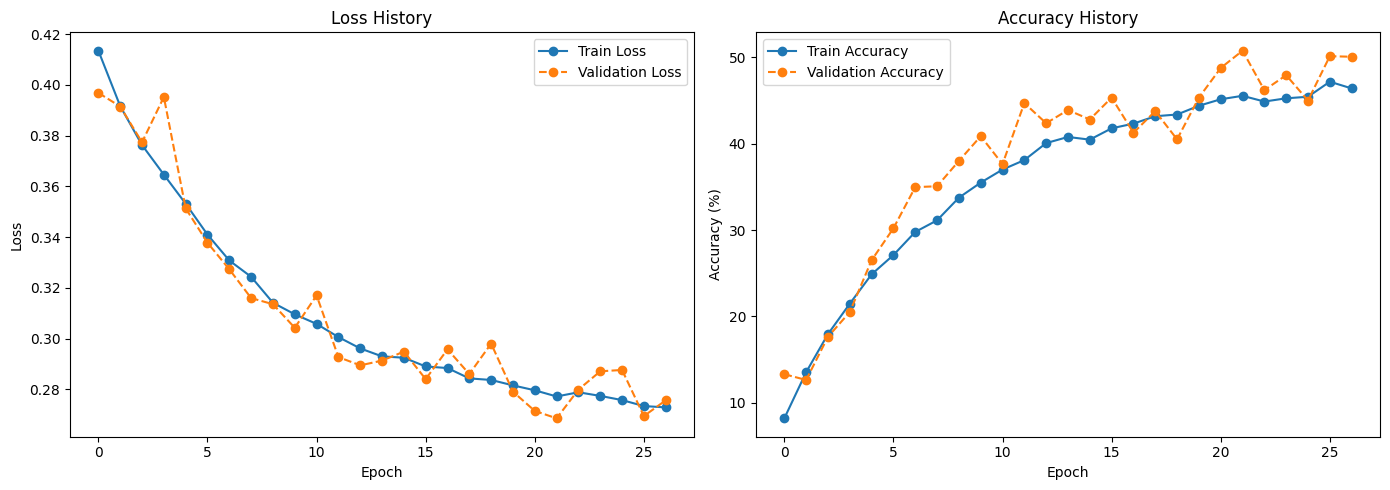

In [ ]:
# 1행 2열 subplot 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss 시각화
axes[0].plot(train_loss_history, label='Train Loss', marker='o')
axes[0].plot(val_loss_history, label='Validation Loss', marker='o', linestyle='--')
axes[0].set_title('Loss History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy 시각화
axes[1].plot(train_acc_history, label='Train Accuracy', marker='o')
axes[1].plot(val_acc_history, label='Validation Accuracy', marker='o', linestyle='--')
axes[1].set_title('Accuracy History')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# 테스트
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Evaluating: 100%|██████████| 375/375 [06:01<00:00,  1.04it/s, Loss=0.2734, Accuracy=49.10%]

Test Loss: 0.2734, Test Accuracy: 49.10%


In [ ]:
!nvidia-smi

Thu Nov 21 16:05:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              48W / 400W |   6627MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--